# Streambed seepage model of river by Teichert and Rooney
The goal of this MODFLOW model is to apply detailed field data collected over two years to a diffusive wave streamflow routing package. Due to the location of this study, the regional groundwater table is well below the stream (60-80ft) such that the bottom of the model will be modeled as a seepage face. The diffusive wave model will be applied to calibrate the streambed hydraulic conductivities to match the stream stage and floodwave front velocities.

In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import shapefile
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [67]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy/'
if flopy_dir not in sys.path:
    sys.path.append(flopy_dir)
# sys.path
import flopy 

from importlib import reload
# importlib.reload
reload(flopy)

<module 'flopy' from 'C:\\Users\\ajcalder\\Anaconda3\\envs\\geosp\\lib\\site-packages\\flopy\\__init__.py'>

# Time discretization
Streambed stage data was collected from December 2019 to December 2021 and successfully captured the first winter flows for both WY2020 and WY2021.

In [331]:
no_ss = False

In [337]:

# Transient -> might want to think about making SP1 steady
end_date = pd.to_datetime('2020-09-30')
# end_date = '2018-01-02'
strt_date = pd.to_datetime('2019-10-01')

dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
nstp = np.ones(nper)*np.append(np.ones(1),6*np.ones(nper-1))

In [333]:
# adjusters for boundary condition input
if no_ss == True:
    time_tr0 = 0  
    nper_tr = nper 
else:
    time_tr0 = 1
    nper_tr = nper-1


# Grid discretization
The stream stage sensors are installed roughly every 500m in the stream channel, a discretization of 100m is the minimum in the transverse direction of the stream channel or else the stream will fill more space than just one model cell.

In [394]:
delr = 100
delc = 100
rotation=52.9

# model will only be in upper 0-70 ft of the domain, most likely only 0-30ft
unsat_thick = 20 # 20 meter depth roughly
thick = 4
upscale = 8 # from usual 0.5m
nlay = int(unsat_thick/thick)

# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

In [395]:
# load parent model grid
parent_grid = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [396]:
teichert = gpd.read_file(gwfm_dir+'/Mapping/Kautz_shapefiles/Kautz Property.shp').to_crs('epsg:32610')
teichert.geometry = teichert.buffer(200)
# os.listdir(gwfm_dir+'/Mapping/Kautz_shapefiles')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array

In [397]:
df = pd.read_csv(dat_dir+'/instream_sensor_latlong.csv')
rm_sp = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude), crs='epsg:4326')
rm_sp = rm_sp.to_crs('epsg:32610')
rm_sp['id_num'] = rm_sp.Sensor.str.extract(pat=r'(\d+)').astype(float)
rm_sp = rm_sp[rm_sp.Type=='Level']

# filter to Teichert sensors
rm_t = gpd.overlay(rm_sp, teichert)

In [398]:
# join monitoring extent with parent grid
rm_grid = gpd.sjoin(rm_t, parent_grid)
# add 1000 m outward to limit bounary effects
beg_row, beg_col = rm_grid.min()[['row','column']] - int(1000/delr)
end_row, end_col = rm_grid.max()[['row','column']] + int(1000/delr)


C:\Users\ajcalder\AppData\Local\Temp\ipykernel_3668\1578059822.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  beg_row, beg_col = rm_grid.min()[['row','column']] - int(1000/delr)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_3668\1578059822.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  end_row, end_col = rm_grid.max()[['row','column']] + int(1000/delr)


In [399]:

beg_lay = 0
end_lay = 1

child_grid = parent_grid.loc[(parent_grid.row>=beg_row)&(parent_grid.row<end_row)]
child_grid = child_grid.loc[(child_grid.column>=beg_col)&(child_grid.column<end_col)]

child_grid = child_grid.rename({'node':'p_node','row':'p_row','column':'p_column'},axis=1)

In [400]:
child_grid['id'] = 0
m_domain = child_grid.dissolve('id')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\plotting.py:71: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\plotting.py:71: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-pa

<AxesSubplot:>

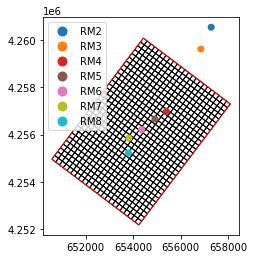

In [401]:
fig,ax=plt.subplots()
# child_extent.plot(ax=ax,color="None")
child_grid.plot(ax=ax, color="None")
m_domain.plot(color="none",edgecolor='red',ax=ax)
rm_gdf.plot('Site_id',legend=True,ax=ax)

In [421]:
# scale the nuber of rows/cols by change in dimensions
ncol = int(200/delr)*(child_grid.p_column.max() - child_grid.p_column.min()) + 1
nrow = int(200/delc)*(child_grid.p_row.max() - child_grid.p_row.min()) + 1

In [403]:
coords = list(m_domain.geometry.values[0].exterior.coords)
xul = np.min(coords)
yul = coords[np.where(coords==xul)[0][0]][1]

In [404]:
loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/'
model_ws = loadpth+'inset_model'

In [422]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mfowhm', 
                          version = 'mfnwt', model_ws=model_ws)

#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [423]:
mg = m.modelgrid
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(654158.6447601715, 4252245.424786887) (650569.517080458, 4254959.8607317405) (654369.7274032533, 4259984.639483339) (657958.8550829669, 4257270.203538486)


In [424]:
# write modelgrid to get updated row and col numbers specific to the child grid
m.modelgrid.write_shapefile(gwfm_dir+'/DIS_data/streambed_seepage/grid/rm_only_grid.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/streambed_seepage/grid/rm_only_grid.shp')
grid_p.crs = 'epsg:32610'

wrote C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel/DIS_data/streambed_seepage/grid/rm_only_grid.shp


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

In [425]:
# find matching based on current grid
grid_match = gpd.sjoin(child_grid, grid_p, op = 'intersects', how = 'left')
# grid_match.row = grid_match.row.astype(int)
# grid_match.column = grid_match.column.astype(int)

Top of child grid needs to coincide with the top of the parent grid if vertical grid refinement is applied
It would be interesting to look at including the transfer of flow between the parent and child model as it is not currently implemented in MODFLOW. Need to create relation between parent and child grid row, column numbers

In [426]:
# np.savetxt(gwfm_dir+'\DIS_data\dem_52_9_rm_local_100m_linear.tsv', dem_data, delimiter = '\t')

# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_rm_local_100m_linear.tsv', delimiter = '\t')
dem_data_p = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')

dem_data = np.zeros((nrow,ncol))
dem_data[grid_match.row-1, grid_match.column-1] = dem_data_p[grid_match.p_row-1, grid_match.p_column-1]


<>:5: DeprecationWarning: invalid escape sequence \D
<>:5: DeprecationWarning: invalid escape sequence \D
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_3668\3738809976.py:5: DeprecationWarning: invalid escape sequence \D
  dem_data_p = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


In [427]:
# model top is the same as the regional model
m.dis.top = np.copy(dem_data)
botm = np.zeros(m.dis.botm.shape)
botm[0,:] = dem_data -  thick
# model bottom is the same as TPROGs bottoms
for k in np.arange(1, nlay):
    botm[k,:] = botm[k-1,:] - thick
    
m.dis.botm = botm

In [428]:
# list(grid_p.unary_union.exterior.coords)
# bounding box of model grid
xmin,ymin,xmax,ymax = grid_p.unary_union.bounds

# corners of model grid
# xmin, ymin = grid_p.geometry.bounds.min()[['minx','miny']]
# xmax, ymax = grid_p.geometry.bounds.max()[['maxx','maxy']]

# LPF

In [172]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')

gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    print('exists')
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

exists


In [167]:
tprogs_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities'
if tprogs_fxn_dir not in sys.path:
    sys.path.append(tprogs_fxn_dir)
# sys.path
import tprogs_cleaning as tc

from importlib import reload
# importlib.reload
reload(tc)

<module 'tprogs_cleaning' from 'C:\\Users\\ajcalder\\Documents/GitHub/CosumnesRiverRecharge/tprogs_utilities\\tprogs_cleaning.py'>

In [429]:
tprogs_info = [80, -80, 320]

#  one based is  min:1, 90:mean, max:34
t=89 #0, 33,89
tprogs_line = np.loadtxt(tprogs_files[t])
# filter elevation by regional model
masked_tprogs= tc.tprogs_cut_elev(tprogs_line, dem_data_p, tprogs_info)
# subset masked data to local model
masked_tprogs_local = np.zeros((tprogs_info[2], nrow, ncol))
masked_tprogs_local[:, grid_match.row-1, grid_match.column-1] = masked_tprogs[:,grid_match.p_row-1, grid_match.p_column-1]

K, Sy, Ss= tc.int_to_param(masked_tprogs_local, params)

# save tprogs facies array as input data for use during calibration
# tprogs_dim = masked_tprogs.shape
# np.savetxt(model_ws+'/input_data/tprogs_facies_array.tsv', np.reshape(masked_tprogs, (tprogs_dim[0]*nrow,ncol)), delimiter='\t')
# masked_tprogs = np.reshape(np.loadtxt(model_ws+'/input_data/tprogs_facies_array.tsv', delimiter='\t'), (320,100,230))


In [430]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)

In [490]:
top = np.copy(m.dis.top.array)
bot1 = np.copy(botm[-1,:,:])
# tprogs_info = ()
from scipy.stats import hmean, gmean

# I need to verify if a flattening layer is needed (e.g., variable thickness to maintain TPROGs connectivity)
# pull out the TPROGS data for the corresponding depths
K_c = tc.get_tprogs_for_elev(K, top, bot1,tprogs_info)
Ss_c = tc.get_tprogs_for_elev(Ss, top, bot1,tprogs_info)
Sy_c = tc.get_tprogs_for_elev(Sy, top, bot1,tprogs_info)

# upscale as preset
for k in np.arange(0,nlay):
    hk[k,:] = np.mean(K_c[upscale*k:upscale*(k+1)], axis=0)
    vka[k,:] = hmean(K_c[upscale*k:upscale*(k+1)], axis=0)
    ss[k,:] = np.mean(Ss_c[upscale*k:upscale*(k+1)], axis=0)
    sy[k,:] = np.mean(Sy_c[upscale*k:upscale*(k+1)], axis=0)


In [492]:
# check proportions of hydrofacies in TPROGs realization
tprogs_hist = np.histogram(masked_tprogs, [0,1.1,2.1,3.1,4.1])[0]
tprogs_hist = tprogs_hist/np.sum(tprogs_hist)

# scale vertical conductivity with a vertical anisotropy factor based
# on quantiles in the upscaled tprogs data
for n, p in enumerate(np.arange(1,5)):
    vka[vka >np.quantile(vka, (1-tprogs_hist[n]))] /= params.vani[p]

In [493]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# laytyp = np.ones(nlay)  
# laytyp = np.zeros(nlay)
# try making first 10 layers convertible/ unconfined, model crashes trying to convert wet/dry
num_unconf = 0
laytyp = np.append(np.ones(num_unconf), np.zeros(nlay-num_unconf))

# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

gel = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = vka, 
                               sy=sy, ss=ss,
                            laytyp=laytyp, laywet = 0, ipakcb=55) # laywet must be 0 for UPW

# gel = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, 
# #                                ss = storativity, storagecoefficient=True, #storativity
#                                ss=ss, 
#                                laytyp=laytyp, laywet = laywet, ipakcb=55)

In [495]:
# gel.write_file()

# BAS6

In [468]:
ibound = np.ones((nlay,nrow,ncol))
# to maintain gw flow gradient that mimics ground surface slope shanafield used a CHD at up and down stream
# ibound[:,:,0] = -1
# ibound[:,:,-1] = -1

#originally started heads 5 m below stream bottom but gw mound started connection in middle reaches
strt = np.zeros(ibound.shape)
strt[:] = m.dis.top.array
# strt = np.reshape(XSg.z_m_min.values, (nrow,ncol)) - 10 # start heads below the stream bottom



In [470]:
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
# add option: STOPERROR 0.01 to reduce percent error when OWHM stops model
# if solver criteria are not met, the model will continue if model percent error is less than stoperror
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt, stoper = 1) #

# SFR

In [432]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')

# find XS that are in the modeled domain by thalweg point
thalweg = xs_all[xs_all.dist_from_right_m==100]
thalweg = gpd.overlay(thalweg, grid_p)
# thalweg = thalweg.cx[xmin:xmax, ymin:ymax]

# pivot based on XS number and save only elevation in z_m
xs_all_df = pd.read_csv(dat_dir+'Elevation_by_XS_number_meters.csv',index_col=0)
xs_all_df = xs_all_df.dropna(axis=0,how='any')

# filter XS by those that are within the domain bounds
xs_all = xs_all[xs_all.xs_num.isin(thalweg.xs_num.values)]
xs_all_df = xs_all_df.loc[:, thalweg.xs_num.astype(str)]

# renumber XS
thalweg.xs_num = np.arange(0,thalweg.shape[0])
xs_all.xs_num = np.repeat(thalweg.xs_num.values,xs_all.dist_from_right_m.max()+1)
xs_all_df.columns = thalweg.xs_num

In [433]:
from shapely.geometry import LineString
i = 0
# Number of cross sections
numxs = int(len(xs_all_df.columns))
# i is the cross-section number
lp = pd.DataFrame(np.linspace(1,int(numxs),int(numxs)))
lp['geometry'] = LineString([(0,0),(0,1)])

for i in np.arange(0,numxs): #numxs
    # Number of points in each cross section
    numl = np.sum(pd.notna(xs_all_df.iloc[:,i]))
    # Create empty array to fill with coordinates
    lines = np.zeros((numl,2))
    # j is the number of points in each individual cross-section
    lm = LineString(list(zip(xs_all_df.index.values, xs_all_df.iloc[:,i].values)))
    tol = 0.6
    deltol = 0.1
    count = 0
    lms = LineString(lm).simplify(tolerance = tol)
    while len(list(lms.coords))>8:
        if len(list(lms.coords)) <5:
            deltol = 0.001
        temp = lms
        lms = LineString(lm).simplify(tolerance = tol)
        tol += deltol
#         if count drops below 8 then reduce deltol
#         if len(list(lms.coords)) <6:
#             lms = temp
#             tol -= deltol
#             deltol *= 0.5     
        count += 1

    print(i,':',len(list(lms.coords)),end = ' - ') #count, 
    lp.geometry.iloc[int(i)] = LineString(lms)
    
# some segments will never be able to match the ideal number of points despite very fine loops

0 : 8 - 1 : 7 - 2 : 8 - 3 : 8 - 4 : 8 - 5 : 8 - 6 : 8 - 

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_3668\2110285611.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lp.geometry.iloc[int(i)] = LineString(lms)


7 : 6 - 8 : 8 - 9 : 8 - 10 : 8 - 11 : 8 - 12 : 8 - 13 : 7 - 14 : 7 - 15 : 8 - 16 : 8 - 17 : 8 - 18 : 7 - 19 : 8 - 20 : 7 - 21 : 8 - 22 : 8 - 23 : 8 - 24 : 8 - 25 : 8 - 26 : 7 - 27 : 8 - 28 : 8 - 29 : 8 - 30 : 7 - 31 : 8 - 32 : 8 - 33 : 8 - 34 : 8 - 35 : 8 - 36 : 8 - 37 : 8 - 38 : 8 - 39 : 8 - 40 : 8 - 41 : 7 - 42 : 8 - 43 : 8 - 44 : 7 - 45 : 8 - 46 : 8 - 47 : 8 - 48 : 8 - 49 : 8 - 50 : 8 - 51 : 7 - 52 : 8 - 53 : 7 - 54 : 8 - 55 : 8 - 56 : 8 - 57 : 8 - 58 : 8 - 59 : 8 - 60 : 8 - 61 : 8 - 62 : 8 - 63 : 8 - 64 : 8 - 65 : 6 - 

In [434]:
XS8pt = pd.DataFrame(np.zeros((numxs*8, 3)), columns=['xs_num','dist_from_right_m','z_m'])
XS8pt.xs_num = np.repeat(np.arange(0,numxs), 8)

# lpg = gpd.GeoDataFrame(lp[:])
xscoords = np.zeros((8, numxs))
filler = np.zeros(2)
filler[:] = np.nan
for i in np.arange(0, numxs):
    coordtemp = np.array(list(lp.geometry.iloc[i].coords))
    coordtemp = coordtemp[~np.isnan(coordtemp[:,0])]
    # if missing points add to make 8
    while len(coordtemp) < 8:
        endfill = np.copy(coordtemp[-1,:]) # take last and add new point
        endfill[0] += 1 # offset with different x
        coordtemp = np.vstack((coordtemp, endfill))
    # reset distance from right to start at 0
    coordtemp[:,0] -= coordtemp[0,0]
    XS8pt.loc[XS8pt.xs_num==i,['dist_from_right_m','z_m']] = coordtemp   


In [435]:
XS8pt.to_csv(proj_dir + '8pointXS_3D_local.csv', index = False)
XS8pt = XS8pt.set_index('xs_num')


In [436]:
# create summary of XS for creating SFR inputs
xs_wide = xs_all.pivot_table(index='dist_from_right_m',values='z_m',columns='xs_num')
thalweg_pts = xs_wide.idxmin().values.astype(int)
xs_mins = xs_all.set_index(['dist_from_right_m','xs_num']).loc[list(zip(thalweg_pts, xs_wide.columns))]
XSg_in = xs_mins.reset_index('dist_from_right_m')
# XSg = xs_all.dissolve('xs_num', 'mean')
# XSg_in = xs_all.loc[(xs_all.dist_from_right_m==100).values,:].set_index('xs_num').copy() # use center point for assigning segment data
XSg_in['iseg'] = XSg_in.index + 1 # add the segment that corresponds to each cross section

In [437]:
# There is one reach for each cell that a river crosses
NSTRM = -len(XSg_in)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = len(XSg_in) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 60 # mannings constant for SI units, 1.0 for seconds, 86400 for days, 60 for minutes
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 5
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day = 0.001 cfs
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 0.00003*60

sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [438]:
# Add option block at the top of the sfr input file for tabfiles
tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
sfr.options = tab_option
# sfr.options

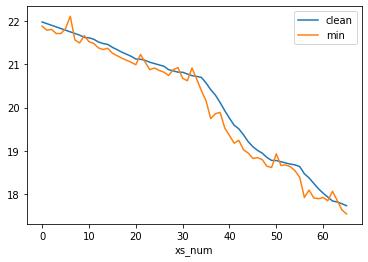

In [439]:
# join segment data to grid
XSg = gpd.sjoin(XSg_in, grid_p)

# find minimum value in XS related to thalweg
XSg['z_m_min'] = xs_all.dissolve('xs_num','min').z_m
#roling mean of 6 window centered removes any negative slope
XSg['z_m_min_cln'] = XSg.z_m_min.rolling(6,center=False).mean()

# calculate slope and fill NAs, fill slope with nearby
z_cln_diff = XSg.z_m_min_cln.diff().bfill()
XSg['slope'] = z_cln_diff.abs()/delr
# correct slope less than 1E-4
XSg.loc[XSg.slope<1E-4,'slope'] = 1E-4

# fix str bot so all is downward sloping
for i in np.arange(len(XSg)-1,-1,-1):
#     if XSg.z_m.values[i] >= XSg.z_m.values[i-1]:
#         XSg.z_m_min_cln.values[i] = XSg.z_m_min_cln.values[i-1] - XSg.slope.values[i]*delr
# fill NAs due to rolling mean
    if XSg.z_m_min_cln.isna()[i]:
        XSg.z_m_min_cln.values[i] = XSg.z_m_min_cln.values[i + 1] + XSg.slope.values[i]*delr

for i in np.arange(0, len(XSg)-1):
    if XSg.z_m_min_cln.values[i+1] >= XSg.z_m_min_cln.values[i]:
        XSg.loc[i+1, 'z_m_min_cln'] = XSg.z_m_min_cln.values[i] - XSg.slope.values[i]*delr

# plot, large spike in top elevation causes discontinuity
# plt.plot(m.dis.top.array[0,:])
# plt.plot(m.dis.botm.array[0,0,:])

XSg.z_m_min_cln.plot(label='clean')
XSg.z_m_min.plot(label='min')
plt.legend()
# XSg.slope.plot(secondary_y = True)

In [440]:
def get_layer_from_elev(elev, botm_slice, nlay):
    """  Return uppermost model layer occupied at least partly by some elevation data
    Parameters
    ----------
    elev: 1D array (n) with elevations matching model elevation units
    botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
    """
    elev_lay = np.zeros(len(elev))
    for k in np.arange(0,nlay-1):
        for j in np.arange(0,len(elev)):
            if botm_slice[k,j] > elev[j]:
                elev_lay[j] = k + 1
    return(elev_lay.astype(int))
                

In [441]:
sfr_rows = (XSg.row.values-1).astype(int)
sfr_cols = (XSg.column.values-1).astype(int)
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
sfr_lay = get_layer_from_elev((XSg.z_m_min_cln.values)-1, botm[:, sfr_rows, sfr_cols], m.dis.nlay)


In [504]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = XSg.node
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = sfr_rows
sfr.reach_data.j = sfr_cols
sfr.reach_data.iseg = XSg.iseg
sfr.reach_data.ireach = 1 
sfr.reach_data.rchlen = 200 #xs_sfr.length_m.values
sfr.reach_data.strtop = XSg.z_m_min_cln.values
sfr.reach_data.slope = XSg.slope.values
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = 1
sfr.reach_data.strhc1 = vka[0, sfr.reach_data.i, sfr.reach_data.j]/10

# UZF parameters
# sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]/100
# sfr.reach_data.thti = sfr.reach_data.thts
# sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]
# sfr.reach_data.uhc = vka[0,sfr.reach_data.i, sfr.reach_data.j]


In [505]:
sfr.write_file()

In [443]:
# mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')


In [444]:
sfr_seg = sfr.segment_data[0].copy()

In [445]:
# alternate version of segment data loading using if statements when filtering data rather than in a loop
sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
# sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion

# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*86400. # m3/day, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [446]:
sfr.segment_data[0] = sfr_seg

In [447]:
# Change column name to float type for easier referencing in iteration
# XS8pt.columns = XS8pt.columns.astype('float')
# XS8pt
# must start at 0 if only at teichert
xsnum = 1

# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(xsnum,len(XSg)+xsnum)}  }


for k in XSg.index:
        XCPT = XS8pt.loc[k].dist_from_right_m.values # old XS8pt[k].index
        ZCPT = XS8pt.loc[k].z_m.values # old XS8pt[k].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [448]:
sfr.check()

passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
0 segments with non-adjacent reaches found.
At segments:


0 segments with non-adjacent reaches found.
At segments:



Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking for streambed tops of less than -10...
passed.

Checking for streambed tops of greater than 15000...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=-66 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
passed.

Checking segment_data for inconsistencies between segment end elevations and the model grid...
Segment elevup and elevdn not 

In [248]:
# FLOWTAB = mb4rl.discharge_va.values
# DPTHTAB = mb4rl.gage_height_va.values
# WDTHTAB = mb4rl.chan_width.values
# sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

## SFR Tab File

In [449]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)

# filter out data between the stress period dates
inflow = inflow.loc[strt_date:end_date]
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))

# # np.arange(0,len(flow_cmd))

time_flow = np.vstack((np.arange(time_tr0,len(inflow.flow_cmd)+time_tr0),inflow.flow_cmd))
time_flow = np.transpose(time_flow)
# add a first row to account for the steady state stress period
# median instead of mean because of too much influence from large values
if no_ss == False:
    time_flow = np.row_stack(([0, inflow.flow_cmd.median()], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

In [450]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

# GHB
Start with example similar to other, assuming no flow boundaries on north and south then higher and lower flow at upper and lower ends.

In [496]:
# join top and botm for easier array referencing for elevations
top_botm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
top_botm[0,:,:] = m.dis.top.array
top_botm[1:,:,:] = m.dis.botm.array


North and south

In [506]:
# for row 0 and -1
distance = 5000

ghb_grid = grid_p[(grid_p.row==1)|(grid_p.row==100)]
ghb_grid = ghb_grid[['row','column']]
ghb_grid -= 1

# layers to set as inflows?
ghb_top = 2
ghb_lay = np.arange(ghb_top,nlay)

ghb_ij= np.repeat(ghb_grid.values, ghb_lay.shape[0], axis=0)

ghb_out = pd.DataFrame(ghb_ij, columns=['i','j'])
ghb_out['k'] =  np.tile(ghb_lay, ghb_grid.shape[0])

ghb_out['bhead'] = dem_data[ghb_out.i,ghb_out.j] - ghb_top*thick
# conductance from geology, scaled by distance
z,y,x = ghb_out.k,ghb_out.i, ghb_out.j
ghb_out['cond'] = hk[z,y,x]*(top_botm[z,y,x]-top_botm[z+1,y,x])*delr/distance

ghb_rows = ghb_out[['k','i','j','bhead','cond']].values

East and west

In [507]:
# for row 0 and -1
distance = 5000


ghb_grid = grid_p[(grid_p.column==1)|(grid_p.column==ncol)]
ghb_grid = ghb_grid[['row','column']]
ghb_grid -= 1

# layers to set as inflows?
ghb_top = 2
ghb_lay = np.arange(ghb_top,nlay)

ghb_ij= np.repeat(ghb_grid.values, ghb_lay.shape[0], axis=0)

ghb_out = pd.DataFrame(ghb_ij, columns=['i','j'])
ghb_out['k'] =  np.tile(ghb_lay, ghb_grid.shape[0])

ghb_out['bhead'] = dem_data[ghb_out.i,ghb_out.j] - ghb_top*thick
# conductance from geology, scaled by distance
z,y,x = ghb_out.k,ghb_out.i, ghb_out.j
ghb_out['cond'] = hk[z,y,x]*(top_botm[z,y,x]-top_botm[z+1,y,x])*delr/distance


ghb_cols = ghb_out[['k','i','j','bhead','cond']].values

In [515]:

ghb_spd = ghb_cols
ghb_spd = np.vstack((ghb_cols, ghb_rows))

# GHB for east and west model boundaries
ghb = flopy.modflow.ModflowGhb(model=m, stress_period_data =  {0: ghb_spd},ipakcb=55)
# GHB for only Delta, west side of model
# ghb.stress_period_data =  {0: ghbdn_spd}

In [517]:
# ghb.write_file()

# Output Control

In [454]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-strt_date).days
spd = {}
# output file for parallel runs when head/cbc is not needed
for j in month_intervals:
    spd[j,0] = ['print budget']
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True, filenames='MF_parallel.oc')
oc.write_file()


# For later model runs when all the data is needed to be saved
spd = {}
spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}

for j in month_intervals:
    spd[j,0] = ['save head', 'save budget','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

# Solver

In [455]:
nwt = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
                               linmeth=1, iprnwt=1, ibotav=0, options='Specified')
nwt_dict = nwt.__dict__

# load in parameters used by margaret shanafield for DFW
nwt_ex = pd.read_csv(gwfm_dir+'/Solvers/nwt_solver_input_from_dfw.csv', comment='#')
nwt_ex['nwt_vars'] = nwt_ex.NWT_setting.str.lower()
nwt_ex = nwt_ex.set_index('nwt_vars')
nwt_ex = nwt_ex.dropna(axis=1, how='all')
# nwt_ex.select_dtypes([float, int])

for v in nwt_ex.index.values:
    nwt_dict[v] = nwt_ex.loc[v,'Second'].astype(nwt_ex.loc[v,'nwt_dtype'])
    
# correct fluxtol for model units of m3/day instead of m3/second
nwt_dict['fluxtol'] = 500 
    # update NWT sovler parameters
nwt.__dict__ = nwt_dict

nwt.write_file()

# Write input

In [456]:
# Writing the MODFLOW data files
m.write_input()
